# **Projekt PSI**

**Hipoteza:** *Trafienie wroga (zadanie mu obrażeń), bądź jego zniszczenie powoduje pobudzenie gracza związane z emocjonalną reakcją.*

## ***Preprocessing***


### Czyszczenie i łączenie plików:
- ***sample-SUB1107-Face.csv***
- ***sample-SUB1107-BioSigs.csv***
- ***sample-SUB1107-Space._json***
- ***sample-SUB1107-Freud._json***

In [1]:
import pandas as pd
import gc
import json

# czyszczenie pliku "sample-SUB1107-Face.csv"
def clear_face(face_filepath):
    file = pd.read_csv(face_filepath, header=0, delimiter=';')
    col_lst = ['PICTURE-TIMESTAMP', 'IADS-ID', 'IAPS-ID']

    for col in col_lst:
        del file[col]

    gc.collect()

    file = file.dropna(axis=0, subset=['GAME-TIMESTAMP'])

    file = file.rename(columns={'GAME-TIMESTAMP': 'TIMESTAMP'})

    file['TIMESTAMP'] = file['TIMESTAMP'].astype(int)

    file.to_csv('sample-SUB1107-Face-REF.csv', sep=';')
    
    return file


# czyszczenie pliku "sample-SUB1107-BioSigs.csv"
def clear_biosigs(biosigs_filepath):
    file = pd.read_csv(biosigs_filepath, header=0, delimiter=';', low_memory=False)

    file['TIMESTAMP'] = file['TIMESTAMP'].astype(int)

    file = file.groupby('TIMESTAMP', as_index=False).mean()

    file = file.dropna(axis=0)
    
    file.to_csv('sample-SUB1107-BioSigs-REF.csv', sep=';')
    
    return file


# połączenie wyczyszczonych plików
def merge_face_biosigs(face_fpath, biosigs_fpath):
    face = clear_face(face_fpath)
    biosigs = clear_biosigs(biosigs_fpath)

    merged_csv = pd.merge(biosigs, face, on='TIMESTAMP')
    merged_csv.set_index('TIMESTAMP', inplace=True)
    
    merged_csv = merged_csv.dropna(axis=0)
    
    merged_csv.to_csv('sample-SUB1107-Face-BioSigs-merged.csv', sep=';')


# wyciagnięcie rekordów z grą "space"
def space_extract(merged_fpath):
    space = pd.read_csv(merged_fpath, header=0, delimiter=';', low_memory=False)
    
    space = space.loc[space['COND'] == 'space']
    
    del space['COND']
    
    space.set_index('TIMESTAMP', inplace=True)
    
    space.to_csv('sample-SUB1107-space.csv', sep=';')
    
    return space


# wyciagnięcie rekordów z grą "freud"
def freud_extract(merged_fpath):
    freud = pd.read_csv(merged_fpath, header=0, delimiter=';', low_memory=False)
    
    freud = freud.loc[freud['COND'] == 'freud']
    
    del freud['COND']
    
    freud.set_index('TIMESTAMP', inplace=True)
    
    freud.to_csv('sample-SUB1107-freud.csv', sep=';')
    
    return freud


def games_division(merged_fpath):
    space = space_extract(merged_fpath)
    freud = freud_extract(merged_fpath)


# filtruje plik 'game_csv_fpath' na podstawie 'timestamps'
def extract_records_with_right_timestamps(game_csv_fpath, timestamps):
    file = pd.read_csv(game_csv_fpath, header=0, delimiter=';', low_memory=False)
    
    timestamps_plus10 = []
    seconds_after_event = 10
    
    for t in timestamps:
        for i in range(seconds_after_event):
            timestamps_plus10.append(t + i)
    
    file.set_index('TIMESTAMP', inplace=True)
    
    filtered = file.filter(items=timestamps_plus10, axis=0)
    
    no_duplicates = filtered.drop_duplicates()
    
    file = no_duplicates.sort_index()
    
    return file



def filter_game_files(space_fpath, space_timestamps, freud_fpath, freud_timestamps):
    space = extract_records_with_right_timestamps(space_fpath, space_timestamps)
    freud = extract_records_with_right_timestamps(freud_fpath, freud_timestamps)
    
    space.to_csv('sample-SUB1107-space-events.csv', sep=';')
    freud.to_csv('sample-SUB1107-freud-events.csv', sep=';')



# wyciągnięcie rekordów 'Destroy' z .json "space"
def space_json_extract_time(space_json_path):

    timestamps = []

    with open(space_json_path) as json_file:
        data = json.loads(json_file.read())

        for record in data:
            for key, value in record.items():
                if key == 'Asteroid' and value == 'Destroy':
                    timestamps.append(int(record['Timestamp']))

    return tuple(timestamps)


# wyciągnięcie rekordów 'Destroy' z .json "freud"
def freud_json_extract_time(freud_json_path):

    timestamps = []

    with open(freud_json_path) as json_file:
        data = json.loads(json_file.read())

        for record in data:
            for key, value in record.items():
                if key == 'PickUp' and value == 'Destroyed':
                    timestamps.append(int(record['Timestamp']))

    return tuple(timestamps)


def filter_game_files(space_fpath, space_json_path, freud_fpath, freud_json_path):
    space_timestamps = space_json_extract_time(space_json_path)
    freud_timestamps = freud_json_extract_time(freud_json_path)
    
    space = extract_records_with_right_timestamps(space_fpath, space_timestamps)
    freud = extract_records_with_right_timestamps(freud_fpath, freud_timestamps)
    
    space.to_csv('sample-SUB1107-space-events.csv', sep=';')
    freud.to_csv('sample-SUB1107-freud-events.csv', sep=';')


def merge_events(space_fpath, freud_fpath):
    space = pd.read_csv(space_fpath, header=0, delimiter=';', low_memory=False)
    freud = pd.read_csv(freud_fpath, header=0, delimiter=';', low_memory=False)
    
    space.set_index('TIMESTAMP', inplace=True)
    freud.set_index('TIMESTAMP', inplace=True)
    
    file = space.append(freud, ignore_index=True)
    file.to_csv('sample-SUB1107-merged-events.csv', sep=';')
    
    return file

################################################################################

# wywołanie
merge_face_biosigs("../sample/sample-SUB1107-Face.csv", "../sample/sample-SUB1107-BioSigs.csv")
games_division("sample-SUB1107-Face-BioSigs-merged.csv")
filter_game_files("sample-SUB1107-space.csv", "../sample/sample-SUB1107-Space._json",
                  "sample-SUB1107-freud.csv", "../sample/sample-SUB1107-Freud._json")
merge_events("sample-SUB1107-space.csv", "sample-SUB1107-freud.csv")

,ECG,EDA,ANGER,CONTEMPT,DISGUST,FEAR,HAPPINESS,NEUTRAL,SADNESS,SURPRISE
0,-0.002010,8.354187,0.000,0.000,0.000,0.0,0.000,0.962,0.038,0.0
1,0.000783,8.333350,0.000,0.001,0.000,0.0,0.000,0.905,0.095,0.0
2,0.000296,8.335168,0.000,0.001,0.000,0.0,0.000,0.900,0.098,0.0
3,-0.002353,8.440430,0.000,0.000,0.000,0.0,0.000,0.955,0.045,0.0
4,0.003457,8.649670,0.000,0.001,0.000,0.0,0.000,0.751,0.247,0.0
5,-0.000516,8.855432,0.000,0.000,0.000,0.0,0.000,0.956,0.043,0.0
6,-0.000142,8.929077,0.000,0.000,0.000,0.0,0.000,0.993,0.007,0.0
7,0.003012,8.886768,0.000,0.000,0.000,0.0,0.000,0.975,0.025,0.0
8,-0.001071,8.831787,0.000,0.000,0.000,0.0,0.000,0.954,0.046,0.0
9,-0.001362,8.799707,0.000,0.000,0.000,0.0,0.000,0.936,0.063,0.0


# **MODELE**

*Imports*

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

**REGRESJA LINIOWA**

Coefficients:  [0.03322852]
Residual sum of squares: 0.0227
Variance score: 0.1418

Basing on prediction:
Mean Squared Error:  0.022710741154099573
Median Absolute Error:  0.060119069875508746


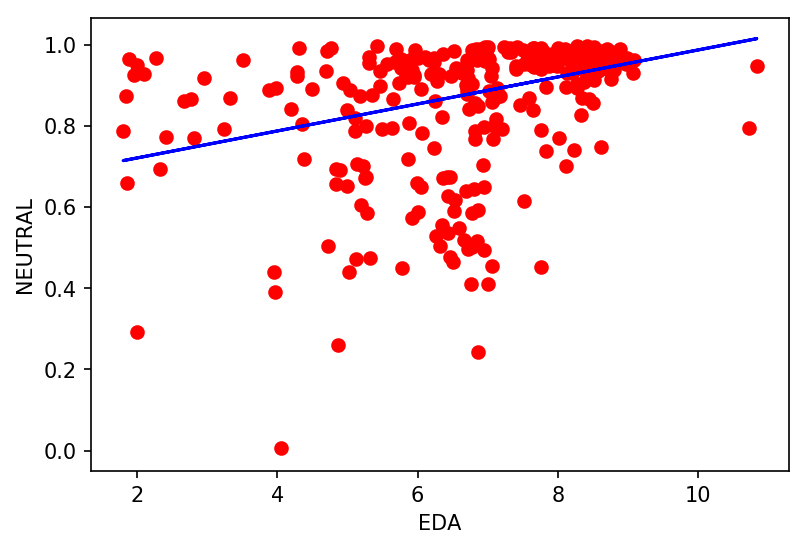

In [3]:
# LINEAR REGRESSION
def linear_regression_model(data_file):
    # X: training data (n_samples)
    # y: target values (n_samples)
    # X, y - arrays of the same size containing data for the regression model

    # data_file = 'sample-SUB1107-merged-events.csv'
    dataset = pd.read_csv(data_file, header=0, delimiter=';', low_memory=False)

    ECG = dataset['ECG']
    EDA = dataset['EDA']
    NEUTRAL = dataset['NEUTRAL']

    X = []
    y = []
    for i in range(len(dataset)):
        X.append([EDA[i]])
        y.append(NEUTRAL[i])

    # Split the data into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

#     # Split the data into training/testing sets
#     X_train = X[101:-101]
#     X1 = X[:100]
#     X2 = X[-100:]
#     X_test = X1 + X2

#     # Split the targets into training/testing sets
#     y_train = y[101:-101]
#     y1 = y[:100]
#     y2 = y[-100:]
#     y_test = y1 + y2

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean square error
    print("Residual sum of squares: %.4f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % regr.score(X_test, y_test))
    
    y_pred = regr.predict(X_test)
    
    print("\nBasing on prediction:")
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    print('Median Absolute Error: ', median_absolute_error(y_test, y_pred))

    # Plot outputs
    plt.figure(dpi=150)
    plt.xlabel('EDA')
    plt.ylabel('NEUTRAL')
    plt.scatter(X_test, y_test, color='red')
    plt.plot(X_test, regr.predict(X_test), color='blue')
    plt.show()

    return regr

# wywołanie
linear_regr = linear_regression_model('sample-SUB1107-merged-events.csv')

**DRZEWO DECYZYJNE**

In [10]:
# DECISION TREE
def decision_tree_model(data_file):
    dataset = pd.read_csv(data_file, header=0, delimiter=';', low_memory=False)
        
    Y = dataset['NEUTRAL']
    X = []
    ECG = dataset['ECG']
    ANGER = dataset['ANGER']
    HAPPINESS = dataset['HAPPINESS']
    SADNESS = dataset['SADNESS']
    
    for i in range(len(dataset)):
        X.append([ECG[i], ANGER[i], HAPPINESS[i], SADNESS[i]])

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

    clf_mse = DecisionTreeRegressor(criterion='mse', random_state=100,
                                    max_depth=10, min_samples_leaf=5)

    clf_mse.fit(X_train, y_train)

    y_pred = clf_mse.predict(X_test)

    # The mean square error
    print("Residual sum of squares: %.4f"
          % np.mean((clf_mse.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % clf_mse.score(X_test, y_test))

    print("\nBasing on prediction:")
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    print('Median Absolute Error: ', median_absolute_error(y_test, y_pred))
    
    return clf_mse

# wywołanie
tree = decision_tree_model('sample-SUB1107-merged-events.csv')

Residual sum of squares: 0.0024
Variance score: 0.9094

Basing on prediction:
Mean Squared Error:  0.00239855470569884
Median Absolute Error:  0.0015999999999998238


**SVR**

In [5]:
# Support Vector Regression - SVR
def SVR_model(data_file):
    dataset = pd.read_csv(data_file, header=0, delimiter=';', low_memory=False)

    Y = dataset['NEUTRAL']
    X = []
    ECG = dataset['ECG']
    EDA = dataset['EDA']
    ANGER = dataset['ANGER']
    HAPPINESS = dataset['HAPPINESS']
    CONTEMPT = dataset['CONTEMPT']
    DISGUST = dataset['DISGUST']
    FEAR = dataset['FEAR']
    SURPRISE = dataset['SURPRISE']
    SADNESS = dataset['SADNESS']
    
    for i in range(len(dataset)):
        X.append([ECG[i], EDA[i], ANGER[i], HAPPINESS[i], CONTEMPT[i], DISGUST[i], FEAR[i], SURPRISE[i], SADNESS[i]])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

    svr = SVR(kernel='poly', degree=2)
    
    svr.fit(X_train, y_train)

    # The mean square error
    print("Residual sum of squares: %.4f"
          % np.mean((svr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % svr.score(X_test, y_test))
    
    y_pred = svr.predict(X_test)
    
    print("\nBasing on prediction:")
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    print('Median Absolute Error: ', median_absolute_error(y_test, y_pred))
    
    
    return svr

# wywołanie
svr = SVR_model('sample-SUB1107-merged-events.csv')

Residual sum of squares: 0.0032
Variance score: 0.8783

Basing on prediction:
Mean Squared Error:  0.003220316867676669
Median Absolute Error:  0.04765571392111656


## STARE WNIOSKI

Przy ocenie modeli powoływaliśmy się przede wszystkim na wskaźnik *explained_variance_score*, z dokumentacji biblioteki *sklearn*:

***"Best possible score is 1.0, lower values are worse."***
 
**Linear Regression:**
- Przy użyciu parametru *EDA* - *variance_score* = **0.1418**
- Przy użyciu parametru *ECG* - *variance_score* = -0.01
- Przy użyciu obu parametrów (*ECG* i *EDA*) - *variance_score* = 0.1371
 
Wszystkie te wyniki są bardzo mało satysfakcjonujące.

Jednym z czynników który powoduje tak słabe wynik jest to, że w regresji liniowej używamy albo po jednym parametrze albo oba na raz, które nie do końca są ze sobą powiązane (a przynajmniej my ich nie połączyliśmy na tyle dokładnie ze sobą, żeby dawały lepsze wyniki).
 
Zostawiliśmy jeden model, ponieważ chcieliśmy zobaczyć jak rozkłada się ten parametr na wykresie, a przy zastosowaniu dwóch parametrów nie było to możliwe.

**Decision Tree Regression:**
Używamy 5 parametrów, które są wylistowane w kodzie i otrzymujemy wynik variance_score = **0.85**
 
Jest to naszym zdaniem bardzo dobry wynik, powołując się na wspomnianą już wyżej dokumentację. 
 
**Support Vector Regression:**
Używamy wszystkich parametrów zawartych w naszym finalnym, przefiltrowanym pliku i otrzymujemy wynik variance_score = **0.78**
 
Biorąc pod uwagę fakt, że użyte zostały wszystkie parametry, które zostały przez nas przefiltrowane jest to również bardzo dobry wynik.

Oprócz *variance_score*, wyznaczamy również *Mean Squared Error* i *Median Absolute Error*, które mają bardzo małe wartości - dlatego skupiamy się na wskaźniku wariancji.

Biorąc pod uwagę wszystkie wyniki uznaliśmy że najlepszym modelem uczenia maszynowego dla naszych danych jest model ***DRZEWA DECYZYJNEGO***.

## NOWE WNIOSKI

***Zaktualizowane wnioski o dobór najlepszych możliwych parametrów***

Przy ocenie modeli powoływaliśmy się przede wszystkim na wskaźnik *explained_variance_score*, z dokumentacji biblioteki *sklearn*:

***"Best possible score is 1.0, lower values are worse."***
 
**Linear Regression:**
- Przy użyciu parametru *EDA* + *fit_intercept=True* -> *variance_score* = **0.1418**
- Przy użyciu parametru *EDA* + *fit_intercept=False* -> *variance_score* = -0.0603
- Przy użyciu parametru *EDA* + *normalize=True* -> *variance_score* = **0.1418**


- Przy użyciu parametru *ECG* + *fit_intercept=True* -> *variance_score* = -0.01
- Przy użyciu parametru *ECG* + *fit_intercept=False* -> *variance_score* = -28.6979
- Przy użyciu parametru *ECG* + *normalize=True* -> *variance_score* = -0.0104


- Przy użyciu obu parametrów (*ECG* i *EDA*) + *fit_intercept=False* -> *variance_score* = 0.1371
- Przy użyciu obu parametrów (*ECG* i *EDA*) + *fit_intercept=True* -> *variance_score* = -0.6052
- Przy użyciu obu parametrów (*ECG* i *EDA*) + *normalize=True* -> *variance_score* = 0.1371 

Wszystkie te wyniki są bardzo mało satysfakcjonujące.

- Dodanie parametru *normalize* nie zmienia wyników w stosunku do regresji bez podanych parametrów.

- Dodanie parametru *fit_intercept* pogarsza wyniki w stosunku do regresji bez podanych parametrów.


Jednym z czynników który powoduje tak słabe wynik jest to, że w regresji liniowej używamy albo po jednym parametrze albo oba na raz, które nie do końca są ze sobą powiązane (a przynajmniej my ich nie połączyliśmy na tyle dokładnie ze sobą, żeby dawały lepsze wyniki).
 
Zostawiliśmy jeden model, ponieważ chcieliśmy zobaczyć jak rozkłada się ten parametr na wykresie, a przy zastosowaniu dwóch parametrów nie było to możliwe.

**Decision Tree Regression:**
Używamy 5 parametrów, które są wylistowane w kodzie i otrzymujemy wynik variance_score = **0.85**

- Dla *max_depth=2* i *min_samples_leaf=3* -> variance_score = 0.76
- Dla *max_depth=5* i *min_samples_leaf=3* -> variance_score = 0.88
- Dla *max_depth=7* i *min_samples_leaf=3* -> variance_score = 0.90
- Dla *max_depth=8* i *min_samples_leaf=3* -> variance_score = 0.9020
- Dla *max_depth=10* i *min_samples_leaf=3* -> variance_score = 0.9003
- Dla *max_depth=100* i *min_samples_leaf=3* -> variance_score = **0.9106**


- Dla *max_depth=8* i *min_samples_leaf=5* -> variance_score = 0.9078
- Dla *max_depth=10* i *min_samples_leaf=5* -> variance_score = 0.9094
- Dla *max_depth=100* i *min_samples_leaf=5* -> variance_score = **0.9138**

- Dla *max_depth=8* i *min_samples_leaf=6* -> variance_score = 0.9078
- Dla *max_depth=10* i *min_samples_leaf=6* -> variance_score = **0.9094**
- Dla *max_depth=100* i *min_samples_leaf=6* -> variance_score = 0.8959


Wybraliśmy parametry: *max_depth=10 i min_samples_leaf=5* :
- Dla *min_weight_fraction_leaf=0.5* -> variance_score = 0.2052
- Dla *min_weight_fraction_leaf=0.35* -> variance_score = 0.3679
- Dla *min_weight_fraction_leaf=0.2* -> variance_score = 0.5730
- Dla *min_weight_fraction_leaf=0.1* -> variance_score = 0.6737
- Dla *min_weight_fraction_leaf=0.05* -> variance_score = 0.7783
- Dla *min_weight_fraction_leaf=0.0* -> variance_score = **0.9094**

Im mniejszy parametr tym lepszy - dlatego dla *min_weight_fraction_leaf=0.0* variance_score jest najlepsza.

Jest to naszym zdaniem bardzo dobry wynik, powołując się na wspomnianą już wyżej dokumentację. 
 
**Support Vector Regression:**
 
Dla parametru *kernel='linear'* -> varance_score = 0.75
Dla parametru *kernel='poly'* -> varance_score = **0.86**
Dla parametru *kernel='rbf'* -> varance_score = 0.78
Dla parametru *kernel='sigmoid'* -> varance_score = -11792

Dla *kernel='poly' i degree='1'* -> variance_score = 0.7234
Dla *kernel='poly' i degree='2'* -> variance_score = **0.8783**
Dla *kernel='poly' i degree='5'* -> variance_score = 0.7715

Dla *kernel='poly' i degree='2' i gamma='scale'* -> variance_score = **0.8783**
Dla *kernel='poly' i degree='2' i gamma='auto'* -> variance_score = **0.8783**

Biorąc pod uwagę fakt, że użyte zostały wszystkie parametry, które zostały przez nas przefiltrowane jest to również bardzo dobry wynik.

Oprócz *variance_score*, wyznaczamy również *Mean Squared Error* i *Median Absolute Error*, które mają bardzo małe wartości - dlatego skupiamy się na wskaźniku wariancji.

Biorąc pod uwagę wszystkie wyniki uznaliśmy że najlepszym modelem uczenia maszynowego dla naszych danych jest model ***DRZEWA DECYZYJNEGO***.